In [29]:
from numpy import zeros, sin, cos, asarray, dot, empty, amax, ones, concatenate, linspace, arange
from random import seed, uniform
from scipy import linalg, io
from math import pi
from scipy.integrate import odeint
from scipy.io import loadmat, savemat
from matplotlib.pyplot import *
from scipy.special import factorial
import numpy as np
from scipy.linalg import expm, logm

In [17]:
a_21, a_31, a_32, a_41, a_42, a_43, b_1, b_2, b_3, b_4 = [ 5.93529782e-02 , 1.38537148e+00 , 0 , 1.33615916e+00,0,  0, -8.15929805e+00,  9.21037609e+00, 4.38612573e-01, -4.89690613e-01]
c_2 = a_21
c_3 = a_31 + a_32
c_4 = a_41 + a_42 + a_43

def hod_f(f,y0):
    t = 1 # doesn't matter for this
    dt = 0.01
    k1 = f(y0, t)
    k2 = f(y0+ a_21*dt*k1, t + c_2*dt)
    k3 = f(y0+ dt*(a_31*k1 + a_32*k2), t + c_3*dt)
    k4 = f(y0+ dt*(a_41*k1 + a_42*k2 + a_43*k3), t + c_4*dt)
    return 2*((b_1-1)*k1 + b_2*k2 + b_3*k3 + b_4*k4 )/dt

####### System parameters

def nonlin_eq(y,t):
    return np.array([y[0] +0.5*y[0]**2, y[1]])

ts = 0.2 
# Sample states
s0list = []
snlist = []
for i in range(10):
    s0 = [uniform(0, 1), uniform(0, 1)]
# Simulate system forward
    sn = odeint(lin_eq, s0, [0, ts])
    s0list += [s0]
    snlist += [sn[-1]]

In [18]:
snlist

[array([1.1601011 , 0.86867177]),
 array([0.05385249, 0.05389071]),
 array([1.12864457, 0.50474356]),
 array([0.66761488, 0.3305527 ]),
 array([0.38053818, 0.35193916]),
 array([1.31014897, 1.00409509]),
 array([1.08578588, 0.99850823]),
 array([0.45606721, 1.07009895]),
 array([1.353103  , 0.94465754]),
 array([1.08495467, 0.60222132])]

In [22]:
psi_0 = np.array(s0list).T
psi_n = np.array(snlist).T

In [23]:
P = np.dot(psi_n, np.linalg.pinv(psi_0))

In [33]:
logm(P)/ts-np.eye(1)

array([[ 5.68065340e-01, -1.09856692e+00],
       [-9.99999993e-01, -1.33318020e-08]])

In [3]:
Samples = 10000 # Number of random initial conditions for both training and testing data
ts = 0.02 # time spacing between training state measurements
tFinal = 0.3 # time horizon --- used in measuring error

NKoopman = 4 # Number of basis functions (keep inside [2,4])
Nstates = 2 # Number of system states
Ncontrol = 1 # Number of system inputs

timeSteps = round(tFinal/ts)+1



def A_and_G(s_1, s_2): # Uses measurements s(t_k) & s(t_{k+1}) to calculate A and G
    A = np.outer(psi_RK(s_2), psi_RK(s_1).T)
    G = np.outer(psi_RK(s_1), psi_RK(s_1).T)
    return A, G

def new_function_error(n,t): # error bound of an arbitrary function f using its n derivatives at time t 
    total_error = t**(n+1)/factorial(n+1)
    return total_error

In [4]:


# Samples = Number_of_Samples
A = zeros((NKoopman, NKoopman))
G = zeros((NKoopman, NKoopman))

Ps0_list = empty((Samples,NKoopman))
Psi_list = empty((Samples,NKoopman))

for i in range (Samples):

    # Sample states
    s0 = uniform(0, 1)
    s1 = uniform(0, 1)

    # Simulate system forward
    sn = odeint(lin_eq, np.array([s0, s1], [0, ts])
    sn = sn[-1,:]

    # Evaluate basis functions at t = 0 and t = ts
    Ps0_list[i,:] = psi_RK(s0).T
    Psi_list[i,:] = psi_RK(sn).T

    [Atemp, Gtemp] = A_and_G(s0,sn);
    A = A+Atemp
    G = G+Gtemp

Kd = dot(A,linalg.pinv(G)) # more accurate than numpy
print("The identified Koopman operator is \n", Kd)

## Measure maximum local (across one time step) errors in Ψ(s_{k+1}) - Kd*Ψ(s_k)
local_errors = empty([Samples, NKoopman])
for i in range(Samples):
    local_errors[i,:] = abs(Psi_list[i,:]- dot(Kd,Ps0_list[i,:]))
max_local_errors = amax(local_errors, axis = 0)
print('Max local errors in theta: %.5f and dtheta: %.5f ' % tuple(max_local_errors[0:2]))

The identified Koopman operator is 
 [[ 9.99999466e-01  1.99985743e-02  2.00322030e-04  1.40623977e-06]
 [-1.08554237e-04  9.99711243e-01  2.00640448e-02  2.14940817e-04]
 [-1.64512104e-02 -4.45957850e-02  1.00961658e+00  2.23268773e-02]
 [-1.68165533e+00 -4.72750387e+00  9.63999355e-01  1.25047195e+00]]
Max local errors in theta: 0.00000 and dtheta: 0.00091 


In [7]:
np.dot(np.diag(1.02*np.ones(4)), np.ones(4))

array([1.02, 1.02, 1.02, 1.02])

In [13]:
np.dot(1.02/4*np.ones((4,4)), np.ones(4))

array([1.02, 1.02, 1.02, 1.02])

In [36]:
psi_RK(1)

array([1.        , 1.1       , 1.32000001, 1.82600002])

In [24]:
np.dot(logm(Kd)/ts, psi_RK(1))

array([   1.49999966,    3.00000705,    8.30187295, -168.96018023])

In [25]:
np.dot(logm(P)/ts, psi_RK(1))

NameError: name 'P' is not defined

In [7]:
K = logm(Kd)/ts
np.dot(K, psi_RK(2))

array([  3.99999929,  11.99999902,  52.11269586, 108.94890136])

In [8]:
K

array([[ 3.73320242e-07,  9.99999391e-01,  3.48634161e-08,
         1.07436480e-08],
       [ 5.09815562e-06,  8.53394312e-06,  9.99996598e-01,
        -8.75703516e-08],
       [-1.51310816e-02,  3.78383165e-02,  1.05936812e-02,
         9.97393847e-01],
       [-7.51249396e+01, -2.10503307e+02,  4.50953711e+01,
         1.07705298e+01]])

In [9]:
B = logm(Kd)/ts-np.eye(4)
np.dot(B, psi_RK(1))

array([   0.49999965,    1.50000699,    5.30190674, -174.98691522])

In [10]:
x = 2
print(0.5*x**2, np.dot(B, psi_RK(x)))

print(x+0.5*x**2, np.dot(K, psi_RK(x)))

2.0 [ 1.99999929  7.99999902 40.11269579 56.94890082]
4.0 [  3.99999929  11.99999902  52.11269586 108.94890136]


In [29]:
def new_f(u,t):
    return u + np.dot(B,psi_RK(u))[0]
def no_f(u,t):
    return u
def new_g(u,t):
    return np.dot(K,psi_RK(u))[0]

In [12]:
import matplotlib.pyplot as plt


In [37]:
ts*115

2.3000000000000003

In [22]:
u0 = 1
psi = psi_RK(u0)
u_list = [u0]
t_list = [0]
t = 0
for i in range(50):
    psi = np.dot(Kd,psi_RK(psi[0]))
    u_list += [psi[0]]
    t = (i+1)*ts
    t_list +=[t]

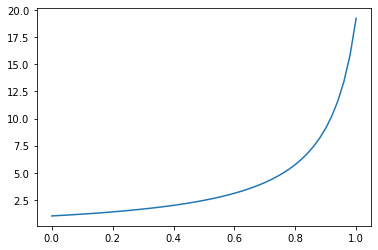

In [23]:
plt.plot(t_list, u_list)

In [24]:
t_space[1]

NameError: name 't_space' is not defined

In [25]:
def euler(f, u0, t_space):
    u_list = [u0]
    u = u0
    dt = t_space[1]-t_space[0]
    for t in t_space:
        du = f(u, t)
        u = u +dt*du
        u_list += [u]
    return u_list[:-1]
    
    

In [26]:
x = 5
print(np.dot(Kd, psi_RK(x))[0])
dx = ts*np.dot(K, psi_RK(x))[0]
dx_true = ts*lin_eq(x,1)
print(x +dx)
print(x +dx_true)
print(odeint(lin_eq, x, [0,ts])[-1])

5.372322785074854
5.350000098590999
5.35
[5.37232722]


In [68]:
expm(K*ts)-Kd

array([[-1.11022302e-16, -4.51028104e-17,  3.70417672e-16,
         2.16293675e-16],
       [ 1.02321580e-17, -1.11022302e-15,  5.20417043e-16,
         2.52185425e-16],
       [ 2.53269627e-16,  3.33066907e-16, -2.22044605e-16,
         1.21430643e-16],
       [-2.22044605e-16, -6.21724894e-15, -2.22044605e-16,
         6.66133815e-16]])

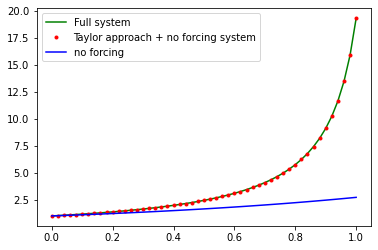

In [33]:
u0 = 1
t_space = np.linspace(0, 1,51)
u1 = odeint(lin_eq, u0, t_space)
plt.plot(t_space, u1.T[0], 'g-', label = 'Full system')
u1 = odeint(new_f, u0, t_space)
plt.plot(t_space, u1.T[0], 'r.',label = 'Taylor approach + no forcing system')
u1 = odeint(no_f, u0, t_space)
plt.plot(t_space, u1.T[0], 'b', label = 'no forcing')
plt.legend()

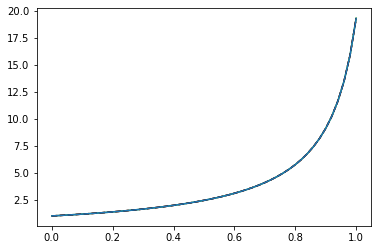

In [28]:
u0 = 1
t_space = np.linspace(0, 1,51)
u1 = odeint(lin_eq, u0, t_space)
plt.plot(t_space, u1.T[0], 'g-',, label = 'Full system')
u1 = odeint(new_f, u0, t_space)
plt.plot(t_space, u1.T[0], 'r--')
u1 = odeint(new_f, u0, t_space)
plt.plot(t_space, u1.T[0], 'r--')
u1 = odeint(new_g, u0, t_space)
plt.plot(t_space, u1.T[0], 'k--')
plt.plot(t_list, u_list)

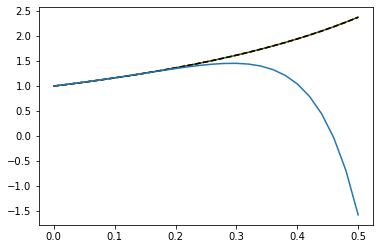

In [62]:
u0 = 1
t_space = np.linspace(0, 0.5,26)
u1 = euler(lin_eq, u0, t_space, label = 'Full system')
plt.plot(t_space, u1, 'g-')
u1 = euler(new_f, u0, t_space)
plt.plot(t_space, u1, 'r--')
u1 = euler(new_g, u0, t_space)
plt.plot(t_space, u1, 'k--')
plt.plot(t_list, u_list)

In [14]:
Psi_list.T

array([[ 3.18092114, -4.29945204,  2.95394425, ..., -3.21662474,
         0.32952771,  2.39897046],
       [ 3.18092114, -4.29945204,  2.95394425, ..., -3.21662474,
         0.32952771,  2.39897046],
       [ 3.18092116, -4.29945206,  2.95394427, ..., -3.21662476,
         0.32952771,  2.39897048],
       [ 3.18092117, -4.29945209,  2.95394428, ..., -3.21662478,
         0.32952772,  2.39897049]])

In [41]:
P = np.dot(Psi_list.T, np.linalg.pinv(Ps0_list.T))
dot(P, Ps0_list.T)

array([[-1.64151085,  0.37096081,  4.00790293, ..., -2.50711338,
        -4.83733277,  2.81905411],
       [-1.37205461,  0.38472182,  5.61423208, ..., -1.8785515 ,
        -2.49735331,  3.61376075],
       [-0.92153651,  0.41323761, 10.11457711, ..., -0.93658275,
        -0.08115266,  5.65124423],
       [-0.23522792,  0.47061308, 24.53512042, ...,  0.2409406 ,
         1.25463803, 11.4499375 ]])

In [43]:
logm(P)/ts

array([[-5.32786931e-06,  1.00000834e+00, -3.56419963e-06,
         3.97960790e-07],
       [-8.35250658e-07,  1.44777749e-06,  9.99999004e-01,
         1.51062145e-07],
       [ 1.38712766e-04, -3.80248131e-04,  3.93221087e-04,
         9.99897018e-01],
       [-1.77117341e+01,  4.00677584e+01, -3.17454753e+01,
         1.00215642e+01]])

In [23]:
np.log(dot(P, psi_RK(1))[0])/ts

1.000978691784143

In [30]:
np.dot(logm(Kd)/ts, np.ones(4))

array([0.99999315, 0.99999315, 1.00000207, 1.00001259])

In [24]:
np.log(dot(Kd, psi_RK(1))[0])/ts

1.000000239925092

In [125]:
np.log(dot(P, psi_RK(1))[0])/ts

1.101108632269795

In [6]:
from scipy.linalg import expm, logm

In [21]:
x = np.random.rand(1)
print(x)
np.dot(logm(Kd)/ts, psi_RK(x))

[0.86578741]


C:\Users\jithi\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


array([0.86578762, 0.86578762, 0.86578762, 0.8657876 ])

In [22]:
x = np.random.rand(1)
print(x)
np.dot(logm(P)/ts, psi_RK(x))

[0.62619557]
logm result may be inaccurate, approximate err = 2.5799146899642926e-10


array([-0.48713938+0.05706452j, -0.48713938+0.05706452j,
       -0.4965499 +0.05676445j,  2.78138118+4.41698992j])

In [ ]:
logm(Kd)/ts

In [135]:
np.dot(logm(np.ones((4,4))*np.exp(ts)/4),np.ones(4))/ts

array([1.+4.62223187e-31j, 1.-2.22044605e-14j, 1.+1.11022302e-14j,
       1.+1.11022302e-14j])

In [134]:
np.dot(np.log(np.ones((4,4))*np.exp(ts)/4),np.ones(4))

array([-5.46517744, -5.46517744, -5.46517744, -5.46517744])

In [112]:
P

array([[ 1.98639703e+01,  1.98650489e+01, -3.87113414e+01,
         2.50111148e-03],
       [ 1.98639703e+01,  1.98650489e+01, -3.87113414e+01,
         2.50111148e-03],
       [ 1.98675787e+01,  1.98686066e+01, -3.87185726e+01,
         2.50705227e-03],
       [ 3.86470730e+01,  3.86492029e+01, -7.62524731e+01,
        -2.35748650e-02]])

In [70]:
s0 = 1
sn = odeint(lin_eq, s0, [0, ts])
sn = sn[-1,:]
sn

array([1.0080321])

In [71]:
dot(Kd,psi_RK(s0))

array([0.40926103, 0.40926103, 0.40926103, 0.40926103])

In [27]:
K = np.diag(np.sum(Kd,axis =0))
dot(K,psi_RK(s0))

array([1.02020134, 1.02020134, 1.02020135, 1.02020136])

In [44]:
np.log(s0*np.exp(np.diag(np.ones(2))*ts))/ts

array([[47.77304555, 46.77304555],
       [46.77304555, 47.77304555]])

In [58]:
A = np.log(s0*np.exp(np.diag(np.ones(4)*ts)))/ts

In [60]:
A = np.log(s0*Kd)/ts

In [57]:
np.log(dot(Kd,psi_RK(s0))[0]/s0)/ts

1.0000004285862867

In [61]:
A

array([[-68.31471782, -68.31471782, -68.31471782, -68.31471782],
       [-68.31471782, -68.31471782, -68.31471782, -68.31471782],
       [-68.31471782, -68.31471782, -68.31471782, -68.31471782],
       [-68.31471782, -68.31471782, -68.31471782, -68.31471782]])

In [65]:
dot(A,psi_RK(s0))

array([-273.25887235, -273.25887235, -273.25887235, -273.25887235])

In [66]:
def kooped_lin_eq(x,t):

    return np.log(dot(Kd,psi_RK(s0))[0]/s0)/ts*x
kooped_lin_eq(1,1)

1.0000004285862867

In [29]:
s = [0, 1]
state_K = []
p = Psi_k(s)
for i in range(100):
    p = dot(Kd, p)
    state_K += [p[:2]]
state_nK = []
sn = s
for i in range(100):
    sn = odeint(single_pendulum, sn, [0, ts])
    sn = sn[-1,:]
    state_nK += [sn]    

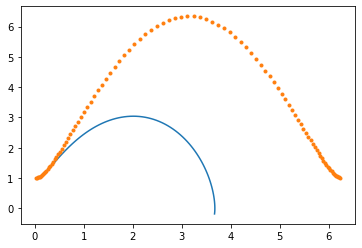

In [30]:
K = np.array(state_K)
import matplotlib.pyplot as plt
plt.plot(K.T[0][0],K.T[0][1])
plt.plot(np.array(state_nK).T[0], np.array(state_nK).T[1], '.')

In [77]:
NKoopman = 6
# Samples = Number_of_Samples
A = zeros((NKoopman, NKoopman))
G = zeros((NKoopman, NKoopman))

Ps0_list = empty((Samples,NKoopman))
Psi_list = empty((Samples,NKoopman))

for i in range (Samples):

    # Sample states
    th0 = uniform(-2*pi, 2*pi)
    dth0 = uniform(-5, 5)
    s0 = [th0, dth0]


    # Simulate system forward
    sn = odeint(single_pendulum, s0, [0, ts])
    sn = sn[-1,:]

    # Evaluate basis functions at t = 0 and t = ts
    Ps0_list[i,:] = Psi_k(s0).T
    Psi_list[i,:] = Psi_k(sn).T

    [Atemp, Gtemp] = A_and_G(s0,sn);
    A = A+Atemp
    G = G+Gtemp

Kd2 = dot(A,linalg.pinv2(G)) # more accurate than numpy
print("The identified Koopman operator is \n", Kd)

## Measure maximum local (across one time step) errors in Ψ(s_{k+1}) - Kd*Ψ(s_k)
local_errors = empty([Samples, NKoopman])
for i in range(Samples):
    local_errors[i,:] = abs(Psi_list[i,:]- dot(Kd2,Ps0_list[i,:]))
max_local_errors = amax(local_errors, axis = 0)
print('Max local errors in theta: %.5f and dtheta: %.5f ' % tuple(max_local_errors[0:2]))

The identified Koopman operator is 
 [[ 9.99999986e-01  1.99999992e-02  1.99941178e-04  1.33316126e-06]
 [-2.74545124e-06  9.99999809e-01  1.99882977e-02  1.99978809e-04]
 [-4.10643633e-04 -5.92806339e-05  9.98244621e-01  1.99920533e-02]
 [-4.08000360e-02 -1.21715886e-02 -1.75518052e-01  9.98223731e-01]]
Max local errors in theta: 0.00000 and dtheta: 0.00000 


In [78]:
Kd2

array([[ 1.00000000e+00,  1.99999993e-02,  1.99999925e-04,
         1.33311038e-06,  6.68876055e-09,  2.53376844e-11],
       [ 1.88410923e-09,  1.00000000e+00,  1.99999893e-02,
         1.99999455e-04,  1.33213065e-06,  6.71257917e-09],
       [ 4.77066163e-07,  9.26335081e-09,  9.99997265e-01,
         1.99999109e-02,  1.99723475e-04,  1.33220068e-06],
       [ 9.52799254e-05, -3.24992602e-06, -5.46984459e-04,
         9.99980127e-01,  1.99446889e-02,  1.99663956e-04],
       [ 1.42734673e-02, -2.51673323e-03, -8.20135963e-02,
        -3.58043033e-03,  9.91699957e-01,  1.99191060e-02],
       [ 1.42330435e+00, -6.59834609e-01, -8.19159164e+00,
        -4.77738607e-01, -8.30748285e-01,  9.85801057e-01]])

In [36]:
s = [0, 1]
state_K2 = []
state_K = []
NKoopman = 4
p = Psi_k(s)
for i in range(50):
    p = dot(Kd, p)
    state_K += [p[:2]]
NKoopman = 6    
p = Psi_k(s)
for i in range(50):
    p = dot(Kd2, p)
    state_K2 += [p[:2]]
state_nK2 = []
sn = s
for i in range(50):
    sn = odeint(single_pendulum, sn, [0, ts])
    sn = sn[-1,:]
    state_nK2 += [sn]
    
K2 = np.array(state_K2)
K = np.array(state_K)

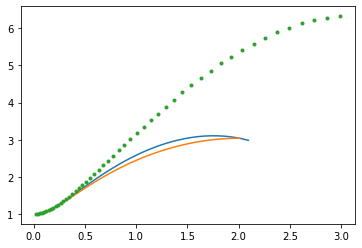

In [37]:

plt.plot(K2.T[0][0],K2.T[0][1])
plt.plot(K.T[0][0],K.T[0][1])
plt.plot(np.array(state_nK2).T[0], np.array(state_nK2).T[1], '.')

In [99]:
NKoopman = 7
# Samples = Number_of_Samples
A = zeros((NKoopman, NKoopman))
G = zeros((NKoopman, NKoopman))

Ps0_list = empty((Samples,NKoopman))
Psi_list = empty((Samples,NKoopman))

for i in range (Samples):

    # Sample states
    th0 = uniform(-2*pi, 2*pi)
    dth0 = uniform(-5, 5)
    s0 = [th0, dth0]


    # Simulate system forward
    sn = odeint(single_pendulum, s0, [0, ts])
    sn = sn[-1,:]

    # Evaluate basis functions at t = 0 and t = ts
    Ps0_list[i,:] = psi_RK(s0).T
    Psi_list[i,:] = psi_RK(sn).T

    [Atemp, Gtemp] = A_and_G(s0,sn);
    A = A+Atemp
    G = G+Gtemp

print('exit1')
KdRK = dot(A,linalg.pinv2(G)) # more accurate than numpy
print("The identified Koopman operator is \n", KdRK)
print('exit2')
## Measure maximum local (across one time step) errors in Ψ(s_{k+1}) - Kd*Ψ(s_k)
local_errors = empty([Samples, NKoopman])
for i in range(Samples):
    local_errors[i,:] = abs(Psi_list[i,:]- dot(KdRK,Ps0_list[i,:]))
max_local_errors = amax(local_errors, axis = 0)
print('Max local errors in theta: %.5f and dtheta: %.5f ' % tuple(max_local_errors[0:2]))

exit1
The identified Koopman operator is 
 [[ 1.00000000e+00  1.99999995e-02  1.99999826e-04  1.33315769e-06
   6.67785933e-09  2.63570388e-11 -2.42847114e-13]
 [ 2.76594412e-10  1.00000000e+00  1.99999894e-02  1.99999513e-04
   1.33128903e-06  6.70974506e-09 -5.60090715e-11]
 [-3.37925512e-09  7.28066628e-08  9.99997249e-01  1.99999207e-02
   1.99478702e-04  1.33131083e-06 -1.60062160e-08]
 [-5.68737043e-07  9.47197900e-06 -5.49903123e-04  9.99982013e-01
   1.98958219e-02  1.99485687e-04 -3.19611938e-06]
 [-3.82580123e-05 -4.67750357e-04 -8.24268132e-02 -3.29823381e-03
   9.84383878e-01  1.98929027e-02 -4.78562349e-04]
 [ 6.61210943e-03 -4.26625737e-01 -8.22788983e+00 -4.49628385e-01
  -1.55887292e+00  9.83292498e-01 -4.76402373e-02]
 [ 1.19377953e-01  2.69800401e+01  1.27599753e+00  4.98509231e-01
   2.85872762e-01 -3.28789269e-01  1.01663807e+00]]
exit2
Max local errors in theta: 0.00000 and dtheta: 0.00000 


In [79]:
s = [1,1]
print(psi_RK(s))
NKoopman = 6 
print(Psi_k(s))

[ 1.00000000e+00  1.00000000e+00  8.25483036e+00  5.30036569e+00
  3.54987916e+01 -1.81633077e+02 -1.92856759e+03 -1.12170174e+04]
[[   1.        ]
 [   1.        ]
 [   8.25483036]
 [   5.30036562]
 [  35.49878869]
 [-181.63316277]]


In [95]:
s = [2, 2]
state_K2 = []
state_K = []
state_RK = []
NKoopman = 4
p = Psi_k(s)
for i in range(50):
    p = dot(Kd, p)
    state_K += [p[:2]]
NKoopman = 6    
p = Psi_k(s)
for i in range(50):
    p = dot(Kd2, p)
    state_K2 += [p[:2]]
NKoopman = 8   
p = psi_RK(s)
for i in range(50):
    p = dot(KdRK, p)
    state_RK += [p[:2]]
state_nK2 = []
sn = s
for i in range(50):
    sn = odeint(single_pendulum, sn, [0, ts])
    sn = sn[-1,:]
    state_nK2 += [sn]
    
K2 = np.array(state_K2)
K = np.array(state_K)
RK = np.array(state_RK)

In [96]:
RK.T[0]

array([2.04177266, 2.08704103, 2.13572083, 2.18771365, 2.24290563,
       2.30116635, 2.36234766, 2.4262828 , 2.49278552, 2.56164949,
       2.63264786, 2.70553306, 2.78003682, 2.85587045, 2.93272541,
       3.01027415, 3.08817118, 3.16605454, 3.2435474 , 3.32026008,
       3.39579229, 3.46973554, 3.54167594, 3.61119713, 3.67788338,
       3.74132296, 3.80111154, 3.8568558 , 3.908177  , 3.95471471,
       3.99613045, 4.03211131, 4.06237351, 4.08666582, 4.10477284,
       4.11651803, 4.12176657, 4.12042789, 4.1124579 , 4.09786089,
       4.07669105, 4.04905355, 4.0151053 , 3.97505509, 3.92916348,
       3.87774204, 3.82115219, 3.7598036 , 3.69415202, 3.62469671])

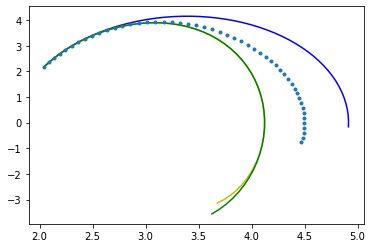

In [97]:
plt.plot(K.T[0][0],K.T[0][1], 'b')
plt.plot(K2.T[0][0],K2.T[0][1], 'y')
plt.plot(RK.T[0],RK.T[1], 'g')

plt.plot(np.array(state_nK2).T[0], np.array(state_nK2).T[1], '.')

In [ ]:
state

In [46]:
sn = odeint(single_pendulum, s, [0, ts])
print(sn[-1,:])

[0.02001308 1.00196258]


In [47]:
sn = dot(Kd, Psi_k(s))
print(sn)

[[0.02001097]
 [1.00175093]
 [0.19597092]
 [9.77105935]]


In [66]:
theta, dtheta = 1,1 
- g/l * cos(theta) * dtheta **3  - 2*(g/l)**2 * sin(theta)**2 * dtheta + (g/l)**2 * cos(2*theta)*dtheta
        

-181.63316277383535